## Generate a synthetic IoT dataset that mimics a real-world scenario for a fictional house

### Import the necessary librairies

In [3]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import warnings
warnings.filterwarnings('ignore')

### Initialize Faker for generating synthetic data

In [5]:
fake = Faker()

# Set a random seed for reproducibility
np.random.seed(42)

# Number of devices
num_devices = 1000

### Generate the dataset

In [7]:
# Device types and models
device_types = ['Thermostat', 'Smart Light', 'Smart Lock', 'Security Camera', 'Smart Speaker']
device_models = {
    'Thermostat': ['T100', 'T200', 'T300'],
    'Smart Light': ['L100', 'L200', 'L300'],
    'Smart Lock': ['SL100', 'SL200', 'SL300'],
    'Security Camera': ['C100', 'C200', 'C300'],
    'Smart Speaker': ['S100', 'S200', 'S300']
}

# Locations in the house
locations = ['Living Room', 'Bedroom', 'Kitchen', 'Bathroom', 'Garage', 'Garden']

# Date range for device installation
start_date = datetime(2018, 1, 1)
end_date = datetime(2023, 1, 1)

# Function to generate a random date
def random_date(start, end):
    return start + timedelta(days=random.randint(0, (end - start).days))

# Generate the dataset
data = []
for i in range(num_devices):
    device_id = f"D{i+1:04d}"
    device_type = random.choice(device_types)
    model = random.choice(device_models[device_type])
    location = random.choice(locations)
    installation_date = random_date(start_date, end_date)
    current_date = datetime(2024, 9, 1)  # Assume the current date is fixed for consistency
    device_age_days = (current_date - installation_date).days
    errors = max(0, int(np.random.poisson(1) + np.random.normal(0, 1)))  # Errors are typically low but can vary
    data.append([device_id, device_type, model, location, installation_date, current_date, device_age_days, errors])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Device_ID', 'Device_Type', 'Model', 'Location', 'Installation_Date', 'Date', 'Device_Age_Days', 'Errors'])

# Add some noise to the 'Errors' to simulate real-world inconsistencies
df['Errors'] = df['Errors'] + np.random.randint(0, 3, size=len(df))

# Shuffle the dataset to randomize the order
df = df.sample(frac=1).reset_index(drop=True)

### Display the first few rows of the dataset

In [9]:
df.head()

,Device_ID,Device_Type,Model,Location,Installation_Date,Date,Device_Age_Days,Errors
0,D0252,Smart Speaker,S300,Bathroom,2019-08-15,2024-09-01,1844,2
1,D0746,Security Camera,C200,Garage,2018-08-07,2024-09-01,2217,3
2,D0447,Smart Speaker,S200,Bedroom,2020-04-03,2024-09-01,1612,2
3,D0813,Smart Light,L300,Kitchen,2018-08-29,2024-09-01,2195,1
4,D0814,Smart Speaker,S100,Garage,2021-09-24,2024-09-01,1073,2


### Save the dataset to a CSV file

In [11]:
df.to_csv('synthetic_iot_devices.csv', index=False)

## Predict maintenance needs 

### Import the necessary librairies

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from datetime import datetime, timedelta
import joblib

### Data Preprocessing

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Device_ID          1000 non-null   object        
 1   Device_Type        1000 non-null   object        
 2   Model              1000 non-null   object        
 3   Location           1000 non-null   object        
 4   Installation_Date  1000 non-null   datetime64[ns]
 5   Date               1000 non-null   datetime64[ns]
 6   Device_Age_Days    1000 non-null   int64         
 7   Errors             1000 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 62.6+ KB


#### Convert "Date" in the appropriate format

In [18]:
df['Installation_Date'] = pd.to_datetime(df['Installation_Date'])
df['Date'] = pd.to_datetime(df['Date'])
df['Device_Age_Days'] = (df['Date'] - df['Installation_Date']).dt.days

#### Check for Missing Values

In [20]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


#### Check for NA values in the DataFrame

In [22]:
na_count = df.isna().sum().sum()

# Print the result
if na_count > 0:
    print(f"There are {na_count} 'NA' values in the DataFrame.")
else:
    print("There is no 'NA' in the DataFrame.")

There is no 'NA' in the DataFrame.


#### Encode categorical variables

In [24]:
# Encode categorical variables
categorical_cols = ['Device_Type', 'Model', 'Location']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


#### Define 'Maintenance_Needed' column based on criteria: errors > 2 or device age > 1000 days

In [26]:
df['Maintenance_Needed'] = np.where((df['Errors'] > 2) | (df['Device_Age_Days'] > 1000), 1, 0)

#### Create Features and Target variable

In [28]:
X = df.drop(['Date', 'Maintenance_Needed', 'Installation_Date', 'Device_ID'], axis=1)
y = df['Maintenance_Needed']

#### Split the data into training and testing sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Selection with GridSearchCV

In [32]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='f1', verbose=2)
grid_search.fit(X_train, y_train)

# Best Model after GridSearch
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


#### Cross-Validation Score

In [34]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-Validation F1-Score: {cv_scores.mean()}")

Cross-Validation F1-Score: 0.9992452830188678


#### Train the best model on the full training set then make prediction

In [36]:
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00       171

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### Error Analysis

#### 1. Review Confusion Matrix

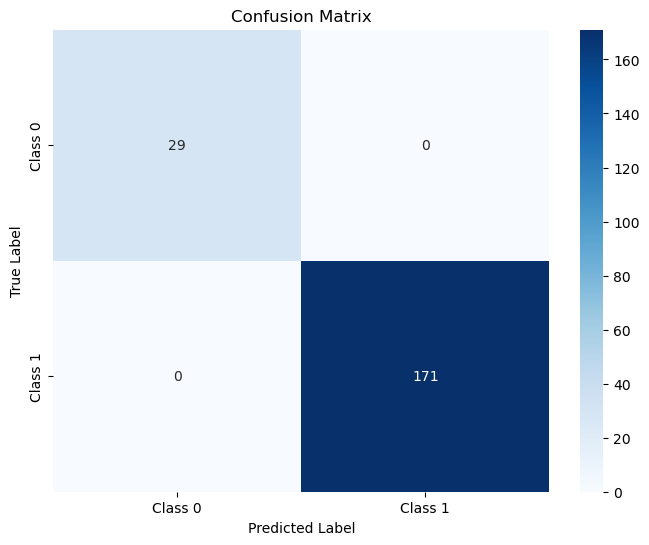

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 2. Identify Misclassified Instances

In [41]:
# Create a DataFrame with predictions and true labels
results = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred
})

# Find misclassified instances
misclassified = results[results['True_Label'] != results['Predicted_Label']]
print("Misclassified Instances:")
print(misclassified)

Misclassified Instances:
Empty DataFrame
Columns: [True_Label, Predicted_Label]
Index: []


#### Feature Importance Analysis

In [43]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importances)


Feature Importances:
                       Feature  Importance
0             Device_Age_Days    0.750692
1                      Errors    0.154617
22            Location_Garden    0.009175
5      Device_Type_Thermostat    0.008840
24       Location_Living Room    0.008738
23           Location_Kitchen    0.008531
18                 Model_T200    0.008217
21            Location_Garage    0.006531
20           Location_Bedroom    0.006134
17                 Model_T100    0.004284
13                 Model_S300    0.003517
19                 Model_T300    0.003414
7                  Model_C300    0.003201
12                 Model_S200    0.003071
3      Device_Type_Smart Lock    0.002445
11                 Model_S100    0.002444
14                Model_SL100    0.002260
16                Model_SL300    0.002144
10                 Model_L300    0.002032
9                  Model_L200    0.002003
2     Device_Type_Smart Light    0.001902
4   Device_Type_Smart Speaker    0.001744
6          

#### Plot feature importance

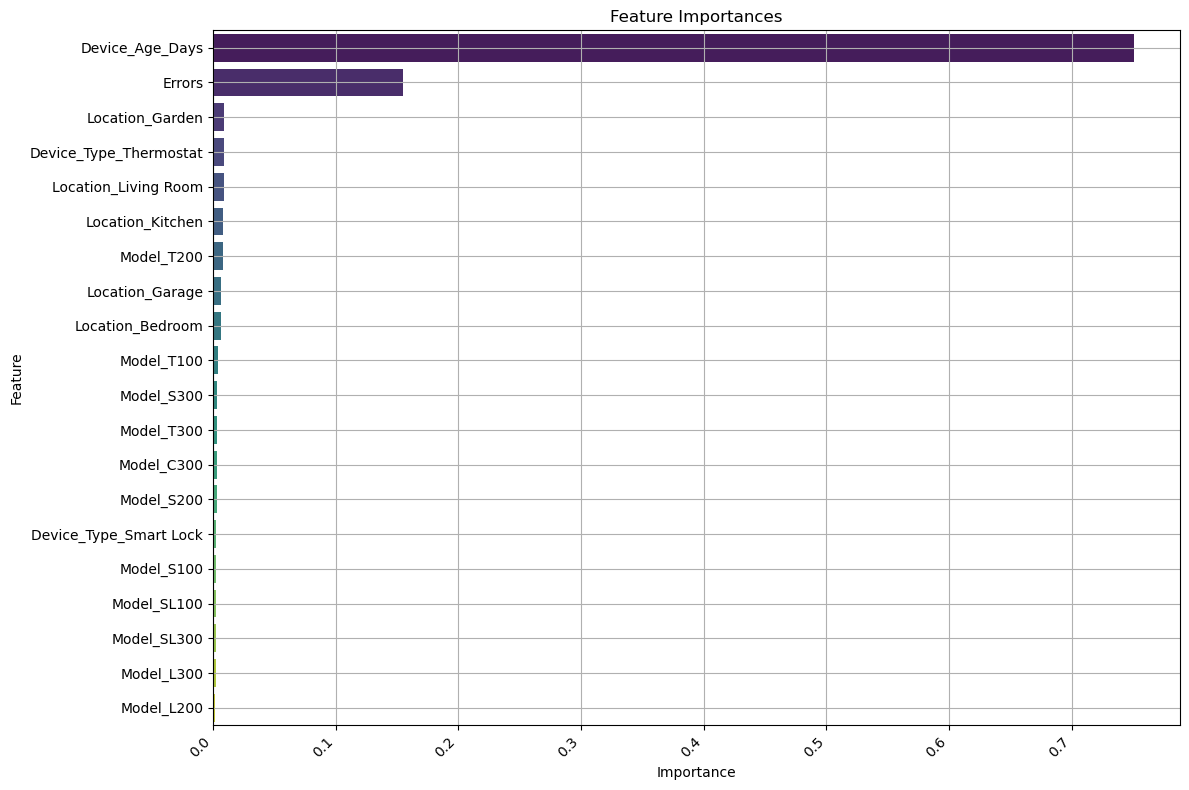

In [45]:
# Sort features by importance  
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)  

# Limit to top N features (e.g., top 20)  
top_n = 20  
feature_importances_top = feature_importances_sorted.head(top_n)  

# Plot the feature importances  
plt.figure(figsize=(12, 8))  
sns.barplot(x='Importance', y='Feature', data=feature_importances_top, palette='viridis')  

plt.title('Feature Importances')  
plt.xlabel('Importance')  
plt.ylabel('Feature')  
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability  
plt.grid(True)  
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels  
plt.show()

### Predict Failures

In [47]:
df['Predicted_Maintenance_Needed'] = best_model.predict(X)

### Identify devices likely to fail within the next 30 days

In [49]:
future_date = df['Date'].max() + timedelta(days=30)
future_predictions = df[df['Date'] <= future_date]

### Schedule Maintenance

In [51]:

# Schedule Maintenance
maintenance_schedule = future_predictions[future_predictions['Predicted_Maintenance_Needed'] == 1]

# Ensure maintenance_schedule has the same features as the original X
X_maintenance = maintenance_schedule[X.columns]


In [52]:
maintenance_schedule['Device_ID'].value_counts()

Device_ID
D0252    1
D0109    1
D0291    1
D0251    1
D0190    1
        ..
D0113    1
D0472    1
D0226    1
D0801    1
D0884    1
Name: count, Length: 831, dtype: int64

### Output maintenance schedule

In [54]:
# Prioritize based on failure probability
maintenance_schedule['Failure_Probability'] = best_model.predict_proba(X_maintenance)[:, 1]
maintenance_schedule = maintenance_schedule.sort_values(by='Failure_Probability', ascending=False)

# Output maintenance schedule
maintenance_schedule = maintenance_schedule[['Device_ID', 'Date', 'Failure_Probability']]
print("\nMaintenance Schedule:\n", maintenance_schedule)



Maintenance Schedule:
     Device_ID       Date  Failure_Probability
390     D0085 2024-09-01             1.000000
349     D0136 2024-09-01             1.000000
379     D0706 2024-09-01             1.000000
378     D0791 2024-09-01             1.000000
377     D0197 2024-09-01             1.000000
..        ...        ...                  ...
398     D0098 2024-09-01             0.771071
72      D0921 2024-09-01             0.757500
44      D0564 2024-09-01             0.756667
294     D0501 2024-09-01             0.744905
998     D0256 2024-09-01             0.730000

[831 rows x 3 columns]


#### Save the schedule to a CSV file

In [56]:
maintenance_schedule.to_csv('maintenance_schedule.csv', index=False)

#### Save the trained model for future use

In [58]:
joblib.dump(best_model, 'best_maintenance_model.pkl')

['best_maintenance_model.pkl']

##  Create the Dash Application

### 1: Install Necessary Libraries

In [61]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

In [62]:

# Load your datasets
device_data = pd.read_csv('synthetic_iot_devices.csv')
maintenance_schedule = pd.read_csv('maintenance_schedule.csv')

# Convert date columns to datetime
device_data['Date'] = pd.to_datetime(device_data['Date'])
maintenance_schedule['Date'] = pd.to_datetime(maintenance_schedule['Date'])

# Ensure both DataFrames have the necessary columns
print(device_data.columns)
print(maintenance_schedule.columns)

# Merge the DataFrames on 'Device_ID' and 'Date'
merged_df = pd.merge(device_data, maintenance_schedule[['Device_ID', 'Date', 'Failure_Probability']],
                     on=['Device_ID', 'Date'], how='left')

# Check the merged DataFrame
print(merged_df.head())


Index(['Device_ID', 'Device_Type', 'Model', 'Location', 'Installation_Date',
       'Date', 'Device_Age_Days', 'Errors'],
      dtype='object')
Index(['Device_ID', 'Date', 'Failure_Probability'], dtype='object')
  Device_ID      Device_Type Model  Location Installation_Date       Date  \
0     D0252    Smart Speaker  S300  Bathroom        2019-08-15 2024-09-01   
1     D0746  Security Camera  C200    Garage        2018-08-07 2024-09-01   
2     D0447    Smart Speaker  S200   Bedroom        2020-04-03 2024-09-01   
3     D0813      Smart Light  L300   Kitchen        2018-08-29 2024-09-01   
4     D0814    Smart Speaker  S100    Garage        2021-09-24 2024-09-01   

   Device_Age_Days  Errors  Failure_Probability  
0             1844       2             0.962667  
1             2217       3             0.996667  
2             1612       2             0.986667  
3             2195       1             0.957619  
4             1073       2             0.973000  


In [63]:
from dash import dcc, html, dash_table
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Load your dataset
device_data = merged_df

# Data preprocessing
device_data['Installation_Date'] = pd.to_datetime(device_data['Installation_Date'])
device_data['Date'] = pd.to_datetime(device_data['Date'])
device_data['Device_Age_Days'] = (device_data['Date'] - device_data['Installation_Date']).dt.days

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.title = "IoT Device Health Monitoring Dashboard"

# Layout of the dashboard
app.layout = html.Div(style={'fontFamily': 'Arial, sans-serif', 'backgroundColor': '#f8f9fa'}, children=[
    html.Div(style={'padding': '10px', 'backgroundColor': '#343a40', 'color': 'white'}, children=[
        html.H1("IoT Device Health Monitoring Dashboard", style={'textAlign': 'center'}),
    ]),

    dcc.Tabs(style={'margin': '20px'}, children=[
        dcc.Tab(label='Device Health Status', style={'backgroundColor': '#f8f9fa'}, selected_style={'backgroundColor': '#e9ecef'}, children=[
            html.Div(style={'padding': '20px'}, children=[
                html.H2("Device Health Status Over Time", style={'textAlign': 'center'}),
                dcc.Dropdown(
                    id='device-dropdown',
                    options=[{'label': device, 'value': device} for device in device_data['Device_ID'].unique()],
                    value=device_data['Device_ID'].unique()[0],
                    style={'width': '80%', 'margin': 'auto'}
                ),
                dcc.Graph(id='health-status-graph')
            ])
        ]),
        dcc.Tab(label='Anomaly Alerts', style={'backgroundColor': '#f8f9fa'}, selected_style={'backgroundColor': '#e9ecef'}, children=[
            html.Div(style={'padding': '20px'}, children=[
                html.H2("Anomaly Alerts", style={'textAlign': 'center'}),
                dcc.Graph(id='anomaly-alerts-graph')
            ])
        ]),
        dcc.Tab(label='Failure Predictions', style={'backgroundColor': '#f8f9fa'}, selected_style={'backgroundColor': '#e9ecef'}, children=[
            html.Div(style={'padding': '20px'}, children=[
                html.H2("Failure Predictions", style={'textAlign': 'center'}),
                dcc.Graph(id='failure-predictions-graph')
            ])
        ]),
        dcc.Tab(label='Historical Data', style={'backgroundColor': '#f8f9fa'}, selected_style={'backgroundColor': '#e9ecef'}, children=[
            html.Div(style={'padding': '20px'}, children=[
                html.H2("Historical Data", style={'textAlign': 'center'}),
                dcc.Graph(id='historical-data-graph')
            ])
        ])
    ])
])

# Callbacks to update the graphs based on selected device
@app.callback(
    Output('health-status-graph', 'figure'),
    [Input('device-dropdown', 'value')]
)
def update_health_status(selected_device):
    filtered_data = device_data[device_data['Device_ID'] == selected_device]
    fig = px.line(filtered_data, x='Date', y=['Device_Age_Days', 'Failure_Probability'],
                  title=f'Device Age and Failure Probability Over Time for {selected_device}')
    fig.update_layout(title_x=0.5, xaxis_title='Date', yaxis_title='Value', template='plotly_white')
    return fig

@app.callback(
    Output('anomaly-alerts-graph', 'figure'),
    [Input('device-dropdown', 'value')]
)
def update_anomaly_alerts(selected_device):
    filtered_data = device_data[device_data['Device_ID'] == selected_device]
    fig = px.scatter(filtered_data, x='Date', y='Errors', color='Errors',
                     title=f'Anomaly Alerts for {selected_device}', color_continuous_scale='Viridis')
    fig.update_layout(title_x=0.5, xaxis_title='Date', yaxis_title='Errors', template='plotly_white')
    return fig

@app.callback(
    Output('failure-predictions-graph', 'figure'),
    [Input('device-dropdown', 'value')]
)
def update_failure_predictions(selected_device):
    filtered_data = device_data[device_data['Device_ID'] == selected_device]
    fig = px.bar(filtered_data, x='Date', y='Failure_Probability',
                 title=f'Failure Predictions for {selected_device}', labels={'Failure_Probability': 'Failure Probability'})
    fig.update_layout(title_x=0.5, xaxis_title='Date', yaxis_title='Failure Probability', template='plotly_white')
    return fig

@app.callback(
    Output('historical-data-graph', 'figure'),
    [Input('device-dropdown', 'value')]
)
def update_historical_data(selected_device):
    filtered_data = device_data[device_data['Device_ID'] == selected_device]
    fig = px.line(filtered_data, x='Date', y=['Device_Age_Days', 'Failure_Probability'],
                  title=f'Historical Data for {selected_device}')
    fig.update_layout(title_x=0.5, xaxis_title='Date', yaxis_title='Value', template='plotly_white')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)